<div style="background-color:black;border-radius:20px 0px;">
    <p style="font-size:25px;color:white; padding:15px; margin-left:39%;font-weight:bolder;">LSTM Model</p>
</div><br><br>
- <b><u>Intuition:</u></b> 
  - LSTM est bien approprié pour les time series , puisque il a la capacité de maintenir le contexte des données , à l'aide d'une cellule mémoire , et des portes d'entrée/sortie et une porte d'oublie (forget gate)

  - LSTM capture bien les dépendances importantes dans le temps meme si ils sont trés dépassés,car il peut connaitre et distinguer entre les informations utiles pour la prédiction en se débarassant des informations inutiles à chaque fois .

  - Ceci permet au modèle LSTM de résoudre les problèmes de RNN , car RNN souffre du problème "Vanishing gradient" cad que les gradients deviennent de plus en plus trés petits ou bien devenir trés large d'un coup ce qui empèche l'apprentissage du reseau RNN .
  
  
- Il existe plusieurs variantes de lstm : 
    - Vanilla LSTM : Contient une seule couche caché , et une autre couche pour faire de la prédiction 
    - Stacked LSTM : il utilise plusieurs couches à la fois .
    - Bidirectionnal lstm,CNN lstm ...
    - Multivariate LSTM models : utiliser plusieurs séries temporelles pour la prédictions .
    
    

- Nous on va se limiter sur Vanilla LSTM , stacked LSTM .



### Importation des librairies

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings
from matplotlib import rcParams
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import backend
from tensorflow.keras.layers import Dropout  
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')
np.random.seed(1)

- On va utiliser le dataset de Apple, pour prédire le prix du stock

### Explore data

In [41]:
data=pd.read_csv("https://raw.githubusercontent.com/krishnaik06/Stock-MArket-Forecasting/master/AAPL.csv")

In [42]:
data.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


- Les données sont journalieres , ils commencent de 27-05-2015 et finissent en 22-05-2020

In [43]:
data.tail()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125,314.96,316.50,310.3241,313.17,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385,313.14,318.52,313.0100,315.03,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215,319.23,319.52,316.2000,316.68,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211,316.85,320.89,315.8700,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754,318.89,319.23,315.3500,315.77,20450754,0.0,1.0


- On va faire les prédictions sur la colonne close 


In [45]:
df1=data.close

## Visualiser les données 

<AxesSubplot:xlabel='close', ylabel='Count'>

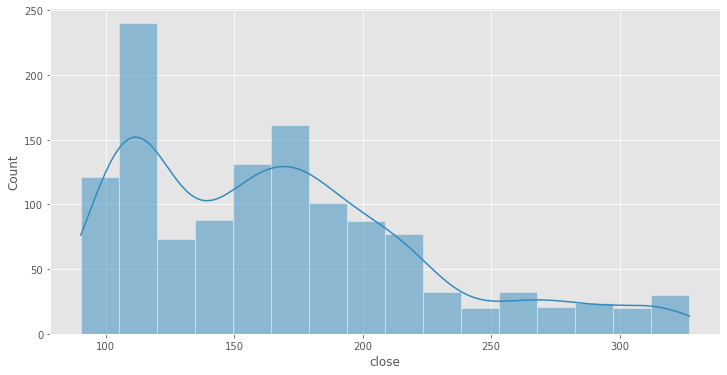

In [46]:
sns.histplot(df1,kde=True)

- les données sont skewed .il y a une grande variabilité 

<AxesSubplot:ylabel='close'>

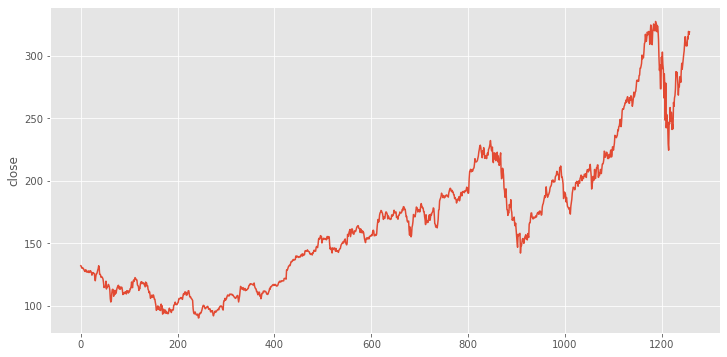

In [47]:
sns.lineplot(data=df1)

- Il ya un trend exponentiel dans les données , avec une saisonnalité qui n'est pas régulière .
- Surement les données sont non stationnaires .
- Puisqu'on va travailler avec un modèle LSTM , se débarasser du trend ou de la saisonnalité reste optionnel , puisque LSTM peut surpasser ces problèmes concernant la stationnarité .

## Test Harness



- Ici on va utiliser un test harness basé sur le moving average .
- C'est une méthode naive puisqu'on suppose rien à propos des données , ni stationnarité ni rien .
- Pour cela on va créer un rolling window , basé sur 20 dérnieres observation , on prenant la moyennes de ces 100 observations .

In [48]:
#Créer un  rolling window de taille 20 qui prend en considération les 5 derniere observations
#créer un nouveau dataframe , pour faciliter les calculs
width = 20
#on doit faire un shift de 1 pour ne pas utiliser la valeur courante dans la prédictions , juste les 5 dérnieres valeurs
my_roll = df1.shift(1).rolling(width).mean()

#Création du DataFrame
my_df = pd.concat([my_roll, df1], axis=1)
#faire un drop des valeurs manquantes .
my_df.dropna(inplace=True)
#calcule de l'erreur
size_train = 1150
rmse = np.sqrt(mean_squared_error(my_df.iloc[:size_train, 0], my_df.iloc[:size_train, 1]))
print('Test-harness RMSE: %.3f' % rmse)

Test-harness RMSE: 7.486


- Comme on a fait pour les dérnieres modèles, on doit avoir un modèle qui surpasse , le modèle de base ou baseline .

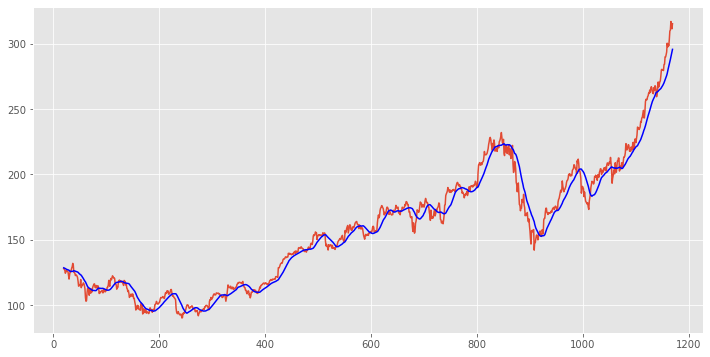

In [49]:
plt.plot(my_df.iloc[:size_train, 1])
plt.plot(my_df.iloc[:size_train, 0], color='blue')
plt.show()

#### Faire un zoom sur les données 


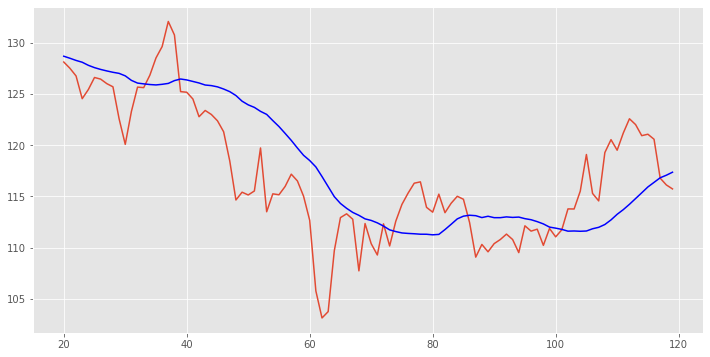

In [50]:
plt.plot(my_df.iloc[:100, 1])
plt.plot(my_df.iloc[:100, 0], color='blue')
plt.show()

## Prepare dataset

- On prépare le dataset , à l'aide de la méthode sliding window , pour cela on va considérer les 20 dérnières lags .

- Mais avant il faut faire un scaling aux données , puisque les modèles LSTM ou les modèles deep learning sont sensibles  à l'echelle des données 


In [51]:
# fit scaler,les donénes
    #Instancier un scaler , il prend les parametres d'intervalle
scaler = MinMaxScaler(feature_range=(0, 1))
    #scaler prend une matrice de deux dim
scaled_data = scaler.fit_transform(df1.values.reshape(-1,1))

In [52]:
#Taille des données
scaled_data.shape

(1258, 1)

- Transformer le problème en un problème d'apprentissage supervisé

In [53]:
def transform_app_sup(data, lag=1):
    df = pd.DataFrame(data)
    
    columns = [df.shift(i) for i in range(1, lag + 1)]

    columns.append(df)

    df = pd.concat(columns, axis=1)

    cols=["lag"+str(i) for i in range(1,lag+2)]

    

    #Il faut se débarasser des lignes nulls
    df = df.dropna().reset_index(drop=True)

    df.columns=cols
    df.rename(columns={"lag"+str(lag+1):"output"},inplace=True)
    return df

 
df2 =  transform_app_sup(scaled_data,20)

In [54]:
df2.head()

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,...,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,output
0,0.154902,0.157350,0.153086,0.158490,0.156042,0.157308,0.154437,0.155493,0.161488,0.162712,...,0.158152,0.161741,0.164739,0.167947,0.167272,0.169699,0.168623,0.174956,0.176074,0.159461
1,0.159461,0.154902,0.157350,0.153086,0.158490,0.156042,0.157308,0.154437,0.155493,0.161488,...,0.156548,0.158152,0.161741,0.164739,0.167947,0.167272,0.169699,0.168623,0.174956,0.156886
2,0.156886,0.159461,0.154902,0.157350,0.153086,0.158490,0.156042,0.157308,0.154437,0.155493,...,0.162712,0.156548,0.158152,0.161741,0.164739,0.167947,0.167272,0.169699,0.168623,0.153719
3,0.153719,0.156886,0.159461,0.154902,0.157350,0.153086,0.158490,0.156042,0.157308,0.154437,...,0.161488,0.162712,0.156548,0.158152,0.161741,0.164739,0.167947,0.167272,0.169699,0.144347
4,0.144347,0.153719,0.156886,0.159461,0.154902,0.157350,0.153086,0.158490,0.156042,0.157308,...,0.155493,0.161488,0.162712,0.156548,0.158152,0.161741,0.164739,0.167947,0.167272,0.148125


In [55]:
#Faire un split des données pour le train et le test, on prend 1150 pour le train 
train_size=1150
train_data , test_data = df2.iloc[0:train_size,:].values,df2.iloc[train_size-20:,:].values

In [56]:
#Taille des données
print(("shape train : "+str(train_data.shape)+"\n"+"shape test: "+str(test_data.shape)+
       "\n il faut rendre les données au format ,tridimmensionnel,pour le training(reshape)"))

shape train : (1150, 21)
shape test: (108, 21)
 il faut rendre les données au format ,tridimmensionnel,pour le training(reshape)


### Reshape des données

In [57]:
X_train,y_train = train_data[:,:20],train_data[:,20]
X_test , y_test = test_data [: ,:20] , test_data[:,20]
# on va faire un reshape  [nb_echantillon , time_steps , features]
X_train = X_train .reshape ( X_train.shape[0] , X_train.shape[1] , 1)
X_test = X_test .reshape ( X_test.shape[0] , X_test.shape[1] , 1)


# Implémenter la structure du modèle LSTM

- Pour le modèle lstm , il existe plusieurs ajustements  à faire pour les hyperparamètres .

- Nous citons : 
   - Nombre de couches 
   - nombre de neurons par couche ou perceptron .
   - le Early stopping : combien de temps , ou d'iterations des mise à jours doit on attendre sachant que le modèle ne diminue pas en RMSE , en ce qui concerne les données de validation , c'est une méthode utilisé pour éviter l'overfitting dans les données . 
   - nombre de couches . 
   - Batch size : definir des slices de données , pour que le modèle fait son training sur ces slices au lieu de faire le training sur toutes les données de train d'un coup , ainsi le modèle va etre entrainé en se basant sur la moyenne des fct couts de chaque slice . 
   - nombre d'epochs : nombre de mise à jour à faire  equivalent à dire un forward et backward propagation , dans le réseau .
   - Le dropout : qte de mises à jours à considérer .
   
- Notre role c'est de trouver un modèle simple pour pouvoir faire des prédictions qui dépassent le baseline model .
- il existe plusieurs méthodes pour trouver ces hyperparamétres : 
   - Optimisation bayésienne 
   - Grid search 
   - Tatonnement 
- Nous on va esssayer plusieurs modèle et essayer de trouver plus ou moins un bon modèle qui performe bien sur les données de test 

In [81]:
#Fonction de création d'un modèle
def create_model(cells, input_size):
    model = Sequential()
    model.add(LSTM(cells,activation="relu", return_sequences=True,
                   input_shape=(input_size, 1),kernel_initializer="lecun_uniform"))
    model.add(LSTM(cells, activation='relu',kernel_initializer='lecun_uniform'))

    model.add(Dense(1))

    #Compilation du modèle

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model


#Fonction d'evaluation du modèle
def Evaluate_model(model,scale):
    errors = list()
    for mod in model:
        train_predict = mod.predict(X_train)
        test_predict = mod.predict(X_test)
        #inverse scaling
        train_predict = scaler.inverse_transform(train_predict)
        test_predict = scaler.inverse_transform(test_predict)
        
        error_test = np.sqrt(mean_squared_error(test_predict, scaler.inverse_transform(y_test[-X_test.shape[0]:].reshape(-1,1))))
        error_train = np.sqrt(mean_squared_error(scaler.inverse_transform(y_train[-X_train.shape[0]-1:].reshape(-1,1)), train_predict))
        errors.append([error_train, error_test])
    df_eval = pd.DataFrame(errors)
    df_eval.columns = ["error_test", "error_train"]
    print(df_eval)
    return train_predict,test_predict

In [69]:
y_test.shape
test_predict = model.predict(X_test)
#inverse scaling

test_predict = scaler.inverse_transform(test_predict)
print(test_predict.shape)

4/4 [==============================] - 0s 5ms/step
(108, 1)


In [80]:
y_test

array([0.79962847, 0.80081061, 0.7983619 , 0.81761378, 0.81875369,
       0.84256523, 0.84210082, 0.84936249, 0.85835515, 0.8866419 ,
       0.87431394, 0.88431985, 0.87836697, 0.8986321 , 0.92582116,
       0.92877649, 0.95676771, 0.93869797, 0.93304061, 0.94950604,
       0.96424048, 0.95512117, 0.95989192, 0.96635143, 0.96246728,
       0.92295027, 0.9598497 , 0.98792536, 0.98594106, 0.92531453,
       0.92172591, 0.96474711, 0.97572406, 0.99159841, 0.96972895,
       0.97614625, 0.96795575, 1.        , 0.99016297, 0.99050072,
       0.96538039, 0.98488559, 0.97086887, 0.94026007, 0.87748037,
       0.83483915, 0.85413324, 0.77336823, 0.77269273, 0.88014017,
       0.84007431, 0.89673225, 0.85527316, 0.83884995, 0.74233725,
       0.82327113, 0.78143207, 0.6665963 , 0.7921557 , 0.64118044,
       0.68614371, 0.66001013, 0.65203074, 0.58642236, 0.56586169,
       0.66089673, 0.65515494, 0.70970193, 0.66452757, 0.69437642,
       0.69218104, 0.63569197, 0.65266402, 0.63780292, 0.72671

In [60]:
#Création du modèle
input_size =train_data.shape[1]-1
model = create_model(12,input_size)

In [61]:
#Verification de la structure du modèle 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 12)            672       
                                                                 
 lstm_5 (LSTM)               (None, 12)                1200      
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


## Entrainement du modèle

In [62]:
num_epochs = 50
batch = 4
model.fit(X_train,y_train,epochs=num_epochs,batch_size=batch,verbose=1)


Epoch 1/50
288/288 [==============================] - 6s 13ms/step - loss: 0.0137
Epoch 2/50
288/288 [==============================] - 4s 13ms/step - loss: 9.1547e-04
Epoch 3/50
288/288 [==============================] - 4s 13ms/step - loss: 8.9841e-04
Epoch 4/50
288/288 [==============================] - 4s 13ms/step - loss: 8.4680e-04
Epoch 5/50
288/288 [==============================] - 4s 12ms/step - loss: 8.9125e-04
Epoch 6/50
288/288 [==============================] - 4s 12ms/step - loss: 7.4338e-04
Epoch 7/50
288/288 [==============================] - 4s 13ms/step - loss: 8.2796e-04
Epoch 8/50
288/288 [==============================] - 4s 13ms/step - loss: 6.8201e-04
Epoch 9/50
288/288 [==============================] - 4s 13ms/step - loss: 6.7734e-04
Epoch 10/50
288/288 [==============================] - 4s 13ms/step - loss: 8.0230e-04
Epoch 11/50
288/288 [==============================] - 4s 13ms/step - loss: 6.3915e-04
Epoch 12/50
288/288 [==============================] - 4

In [82]:
moddeel=[model]
tr_pred,test_pred=Evaluate_model(moddeel,scaler)

4/4 [==============================] - 0s 5ms/step
   error_test  error_train
0    4.454141    14.266765


In [186]:
tr_pred , test_pred=tr_pred.squeeze().tolist(),test_pred.squeeze().tolist()

# Plot results of training 

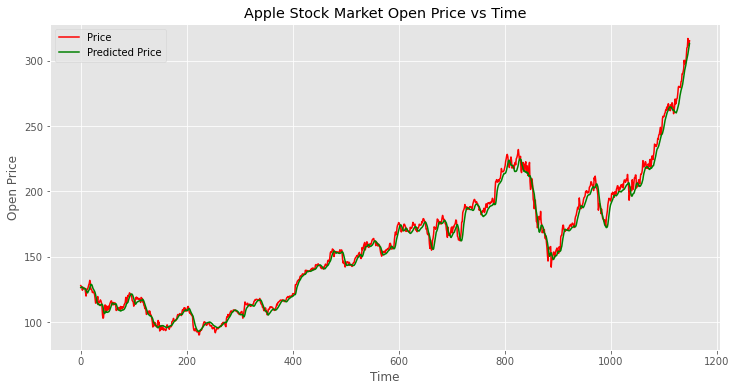

In [86]:

 # error_test = np.sqrt(mean_squared_error(test_predict, scaler.inverse_transform(y_test[-X_test.shape[0]:].reshape(-1,1))))
  #      error_train = np.sqrt(mean_squared_error(scaler.inverse_transform(y_train[-X_train.shape[0]-1:].reshape(-1,1)), train_predict))

plt.plot(scaler.inverse_transform(y_train[-X_train.shape[0]-1:].reshape(-1,1)), color = 'red', label = 'Price')
plt.plot(tr_pred, color = 'green', label = 'Predicted Price')
plt.title('Apple Stock Market Open Price vs Time')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.legend()
plt.show()

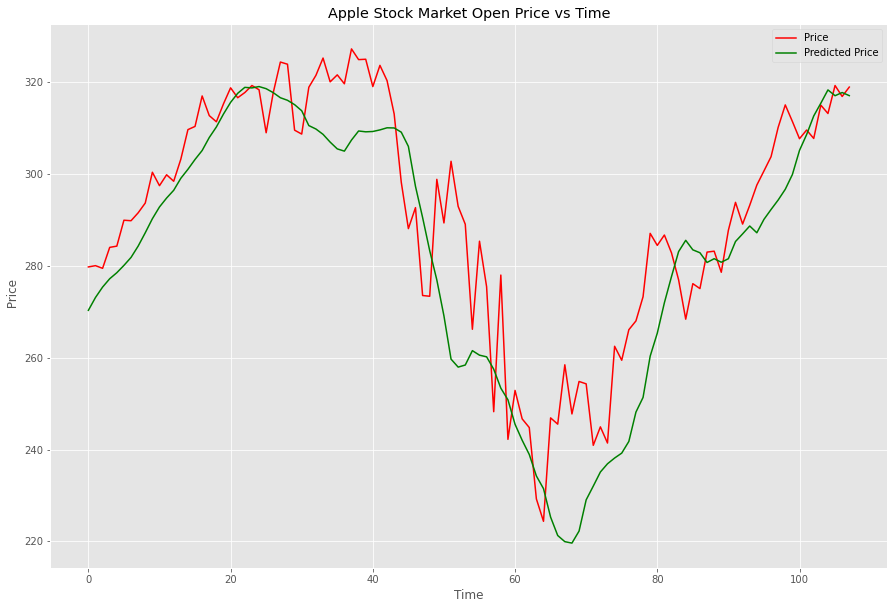

In [88]:
plt.figure(figsize=(15,10))

plt.plot(scaler.inverse_transform(y_test[-X_test.shape[0]:].reshape(-1,1)), color = 'red', label = 'Price')
plt.plot(test_pred, color = 'green', label = 'Predicted Price')
plt.title('Apple Stock Market Open Price vs Time')
plt.xlabel('Time')
plt.ylabel(' Price')
plt.legend()
plt.show()

In [37]:
X_test.shape

(88, 20, 1)

In [38]:
test_data.shape

(88, 21)